# **Machine Learning Methods using German Credit Data**

When a bank receives a loan application, based on the applicant’s profile the bank has to make a decision regarding whether to go ahead with the loan approval or not. Two types of risks are associated with the bank’s decision;

- choosing the wrong customer who is less credit worthy,
- and rejecting the right customer who is high credit worthy.

If the applicant is a good credit risk, i.e. is likely to repay the loan, then not approving the loan to the person results in a loss of business to the bank If the applicant is a bad credit risk, i.e. is not likely to repay the loan, then approving the loan to the person results in a financial loss to the bank.

The German Credit Data contains data on 20 variables and the classification whether an applicant is considered a Good or a Bad credit risk for 1000 loan applicants.
https://www.openml.org/search?type=data&sort=runs&id=31&status=active

This exercise is structured in the following format;

* Data Import and Initial Data Analysis: In this step we import the necessary packages, create the required functions custom to our needs for the purpose of data analysis, visualisation and modelling. We also do some basic checks like missing values, shape of data and remap some categorical values to standard format.

* Exploratory Data Analysis: Where we deep dive into each attribute individually to see if there are any peculiarities about them that needs to be understood and corrected if needed.

* Correlation/Association Analysis: Where we look at relationships among variables to see if there is high degree of correlation and association between any pair of variables.

* Perform Modelling Techniques: In this stage, we apply different modelling techniques on the data and produce output reports to compare which one performs the best.

* Conclusion.

## **Data Import and Initial Data Analysis**

Import packages.

In [ ]:
import pandas as pd
import numpy as np
import json
import os
import urllib.request# import libraires 

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr, spearmanr
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats
from imblearn.over_sampling import SMOTE

Function to calculate Cramér's V statistic between two variables.

In [801]:
# Function to calculate Cramér's V statistic
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min((k-1), (r-1)))

# Example: Association between 'purpose' and 'credit_risk'
# cramers_v(df['purpose'], df['property_magnitude'])

Function to calculate perason's correlation.

In [802]:
def continuous_correlation_table(df, continuous_cols=None):
    """
    Compute Pearson correlation and p-values for all pairs of continuous variables
    
    Parameters:
    - df: Pandas DataFrame
    - continuous_cols: List of continuous column names (if None, use numeric columns)
    
    Returns:
    - DataFrame with columns: ['variable1', 'variable2', "Pearson's r", "p-value"]
    """
    # Select continuous variables if not specified
    if continuous_cols is None:
        continuous_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Initialize results list
    results = []
    
    # Compute for all unique pairs
    for col1, col2 in combinations(continuous_cols, 2):
        # Remove missing values pairwise
        clean_df = df[[col1, col2]].dropna()
        
        # Initialize defaults
        pearson_rho = pearson_p = np.nan
        spearman_rho = spearman_p = np.nan
        
        try:
            # Pearson correlation
            pearson_rho, pearson_p = pearsonr(clean_df[col1], clean_df[col2])
            
            # Spearman's rank correlation
            spearman_rho, spearman_p = spearmanr(clean_df[col1], clean_df[col2])
        except:
            pass
        
        # Store results
        results.append({
            'variable1': col1,
            'variable2': col2,
            "pearson_rho": pearson_rho,
            "pearson_p": pearson_p,
            'spearman_rho': spearman_rho,
            'spearman_p': spearman_p
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df[results_df['variable1'] != results_df['variable2']]  # Remove self-comparisons    
    return results_df

Function to calculate Cramér's V statistic and t-statistic and aggregate the reslts for all the categorical variable combinations.

In [803]:
def categorical_association_table(df, categorical_columns=None):
    """
    Compute Cramér's V and Chi-Square test for all pairs of categorical variables.
    Returns results in a row-wise format (long format).
    
    Parameters:
    - df: Pandas DataFrame
    - categorical_columns: List of categorical column names (if None, use all object/bool columns)
    
    Returns:
    - DataFrame with columns: ['variable1', 'variable2', "Cramér's V", "Chi-Square p-value"]
    """
    # Select categorical columns if not provided
    if categorical_columns is None:
        categorical_columns = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    
    # Initialize results list
    results = []
    
    # Compute for all unique pairs
    for col1, col2 in combinations(categorical_columns, 2):
        # Create contingency table
        contingency_table = pd.crosstab(df[col1], df[col2])
        
        # Chi-Square test
        try:
            chi2, p, _, _ = chi2_contingency(contingency_table)
        except:
            chi2, p = np.nan, np.nan
        
        # Cramér's V
        try:
            cv = cramers_v(df[col1], df[col2])
        except:
            cv = np.nan
        
        # Store results
        results.append({
            'variable1': col1,
            'variable2': col2,
            "Cramér's V": cv,
            "Chi-Square p-value": p
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df[results_df['variable1'] != results_df['variable2']]  # Remove self-comparisons
    
    return results_df

Function for cross-validation evaluation reports

In [804]:
# Function for evaluation reports
def get_eval(clf, X_train, y_train,y_test,y_pred):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    scores2 = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
    scores3 = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    # Create and print confusion matrix
    abclf_cm = confusion_matrix(y_test,y_pred)
    print(abclf_cm)
    return


fit, train and cross validate Logistic regression with training and test data 

In [805]:
# fit, train and cross validate Logistic regression with training and test data 
def logregclf(X_train, y_train,X_test, y_test):
    print("LogisticRegression")
    logreg = LogisticRegression(max_iter=10000).fit(X_train, y_train)

    # Predict target variables y for test data
    y_pred = logreg.predict(X_test)
    print(classification_report(y_test, y_pred))

    # Get Cross Validation and Confusion matrix
    get_eval(logreg, X_train, y_train,y_test,y_pred)
    return

Function to get roc curve data and plot results.

In [806]:
# Function to get roc curve
def get_roc (y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return

function groupby_counts to calculate the counts and default rates for categorical variables

In [807]:
# function groupby_counts to calculate the counts and default rates for categorical variables
def groupby_counts(df, var, desired_order=None):
    df_var =  df.groupby([var]).agg(    
        Total = (var, 'count'),
        good = ('credit_class', lambda x: (x == 'good').sum()),
        bad = ('credit_class', lambda x: (x == 'bad').sum()),
        DefaultRate = ('credit_class', lambda x: (x == 'bad').sum() / len(x))
        ).reset_index()
    
    if desired_order is not None:
        df_var[var] = pd.Categorical(df_var[var], categories=desired_order, ordered=True)

    df_var = df_var.sort_values(var).reset_index(drop=True)
    return df_var


function plot_distribution to plot the distribution and default rates for categorical variables

In [808]:
# function plot_distribution to plot the distribution and default rates for categorical variables
def plot_distribution(df_var, var, value_map=None, loc = (0.7,0.7)):
    
    plt.figure(figsize=(6,4))
    plt.bar(df_var[var], df_var['Total'])
    plt.xlabel(var, fontsize=14)
    plt.xticks(rotation=30)
    plt.ylabel('Count')
    plt.title('Distribution of '+var, fontsize=16, fontweight='bold')

    # Add secondary y-axis for DefaultRate
    ax2 = plt.twinx()
    ax2.plot(df_var[var], df_var['DefaultRate'], color='red', marker='o', label='Default Rate')
    ax2.set_ylabel('Default Rate')

      # Add legend for value_map if provided
    if value_map is not None:
      # Build legend labels
      legend_labels = [f"{v}: {k}" for k, v in value_map.items()]
      # handles = [plt.Rectangle((0,0),1,1, color='white', ec='black', label=f"{k}: {v}") for k, v in value_map.items()]
      desc_text = "xlabels:\n" + "\n".join(legend_labels)
      plt.gcf().text(loc[0], loc[1], desc_text, fontsize=8, 
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.3))
      # plt.legend(handles=handles, title="account_bal_new meaning", loc='upper left')

    plt.show()

function for doing VIF test.

In [ ]:
def calculate_vif(df, cols):
    """
    Calculate Variance Inflation Factor (VIF) for each feature in the dataset.
    
    Parameters:
    - X: DataFrame of features
    
    Returns:
    - DataFrame with VIF values
    """
    X = df[cols]
    X = add_constant(X)  # Add intercept for VIF calculation

    vif_df = pd.DataFrame()
    vif_df["feature"] = X.columns
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif_df)


heatmap of the combined distribution of categorical variables.

In [868]:
def plot_categorical_heatmap(df, var1, var2):
    """
    Plot a heatmap showing frequency relationships between two categorical variables
    
    Parameters:
    - df: DataFrame
    - var1: First categorical variable (str)
    - var2: Second categorical variable (str)
    """
    # Create contingency table
    crosstab = pd.crosstab(df[var1], df[var2])
    
    # Create plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(crosstab, 
                annot=True, 
                fmt='d', 
                cmap='coolwarm', 
                linewidths=.5,
                cbar_kws={'label': 'Count'})
    
    plt.title(f'Relationship between {var1} and {var2}', pad=20)
    plt.xlabel(var2)
    plt.ylabel(var1)
    plt.show()

Plot plot_roc_curve

In [810]:
def plot_roc_curve(fpr, tpr, roc_auc):
    """
    Plot the ROC curve.
    fpr: false positive rate value, 
    tpr: true positive rate value, 
    roc_auc : roc_auc output from roc_auc_score( )
    """
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

Function to import data from json.

In [811]:
def getdata (filepath):
    with open (filepath,'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data)
    return df

**Import the data**

In [812]:
file=os.getcwd()+"\\german_credit_data.json"

In [813]:
df = getdata(file)

Let's look at the data and try to see if we can perform some initial cleaning operations.

In [814]:
df.shape

(1000, 21)

In [815]:
df.head()

,age,checking_status,class,credit_amount,credit_history,duration,employment,existing_credits,foreign_worker,housing,...,job,num_dependents,other_parties,other_payment_plans,own_telephone,personal_status,property_magnitude,purpose,residence_since,savings_status
0,67,<0,good,1169,critical/other existing credit,6,>=7,2,yes,own,...,skilled,1,none,none,yes,male single,real estate,radio/tv,4,no known savings
1,22,0<=X<200,bad,5951,existing paid,48,1<=X<4,1,yes,own,...,skilled,1,none,none,none,female div/dep/mar,real estate,radio/tv,2,<100
2,49,no checking,good,2096,critical/other existing credit,12,4<=X<7,1,yes,own,...,unskilled resident,2,none,none,none,male single,real estate,education,3,<100
3,45,<0,good,7882,existing paid,42,4<=X<7,1,yes,for free,...,skilled,2,guarantor,none,none,male single,life insurance,furniture/equipment,4,<100
4,53,<0,bad,4870,delayed previously,24,1<=X<4,2,yes,for free,...,skilled,2,none,none,none,male single,no known property,new car,4,<100


In [816]:
print(df.columns)

Index(['age', 'checking_status', 'class', 'credit_amount', 'credit_history',
       'duration', 'employment', 'existing_credits', 'foreign_worker',
       'housing', 'installment_commitment', 'job', 'num_dependents',
       'other_parties', 'other_payment_plans', 'own_telephone',
       'personal_status', 'property_magnitude', 'purpose', 'residence_since',
       'savings_status'],
      dtype='object')


In [817]:
df.rename(columns=cols, inplace=True)

check data types and perform appropriate data type conversion.

In [818]:
df.dtypes

age                        int64
account_bal               object
credit_class              object
credit_amount             object
credit_history            object
duration                   int64
employment                object
existing_credits           int64
foreign_worker            object
housing                   object
installment_commitment     int64
job                       object
num_dependents             int64
guarantors                object
other_payment_plans       object
own_telephone             object
personal_status           object
property_magnitude        object
purpose                   object
residence_since            int64
savings_value             object
dtype: object

In [819]:
df['credit_amount'] = df['credit_amount'].astype(float)

check for missing values.

In [820]:
df.isnull().sum(axis=0)

age                       0
account_bal               0
credit_class              0
credit_amount             0
credit_history            0
duration                  0
employment                0
existing_credits          0
foreign_worker            0
housing                   0
installment_commitment    0
job                       0
num_dependents            0
guarantors                0
other_payment_plans       0
own_telephone             0
personal_status           0
property_magnitude        0
purpose                   0
residence_since           0
savings_value             0
dtype: int64

Lets summarise few numerical columns

In [821]:
df.describe()

,age,credit_amount,duration,existing_credits,installment_commitment,num_dependents,residence_since
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000,1.407000,2.973000,1.155000,2.845000
std,11.375469,2822.736876,12.058814,0.577654,1.118715,0.362086,1.103718
min,19.000000,250.000000,4.000000,1.000000,1.000000,1.000000,1.000000
25%,27.000000,1365.500000,12.000000,1.000000,2.000000,1.000000,2.000000
50%,33.000000,2319.500000,18.000000,1.000000,3.000000,1.000000,3.000000
75%,42.000000,3972.250000,24.000000,2.000000,4.000000,1.000000,4.000000
max,75.000000,18424.000000,72.000000,4.000000,4.000000,2.000000,4.000000


### Remap categorical fields

Since the data has many categorical attributes, each with multiple levels, lets recode the levels of each attribute to something more simple, as it will be benefitial for further processes.

In [822]:
df.head()

,age,account_bal,credit_class,credit_amount,credit_history,duration,employment,existing_credits,foreign_worker,housing,...,job,num_dependents,guarantors,other_payment_plans,own_telephone,personal_status,property_magnitude,purpose,residence_since,savings_value
0,67,<0,good,1169.0,critical/other existing credit,6,>=7,2,yes,own,...,skilled,1,none,none,yes,male single,real estate,radio/tv,4,no known savings
1,22,0<=X<200,bad,5951.0,existing paid,48,1<=X<4,1,yes,own,...,skilled,1,none,none,none,female div/dep/mar,real estate,radio/tv,2,<100
2,49,no checking,good,2096.0,critical/other existing credit,12,4<=X<7,1,yes,own,...,unskilled resident,2,none,none,none,male single,real estate,education,3,<100
3,45,<0,good,7882.0,existing paid,42,4<=X<7,1,yes,for free,...,skilled,2,guarantor,none,none,male single,life insurance,furniture/equipment,4,<100
4,53,<0,bad,4870.0,delayed previously,24,1<=X<4,2,yes,for free,...,skilled,2,none,none,none,male single,no known property,new car,4,<100


In [879]:
account_bal_map = {
    'no checking': '0',
    '<0': '1',
    '0<=X<200': '2',
    '>=200': '3'
}

credit_history_map = {
    'critical/other existing credit' : '0', 
    'existing paid' : '1',
    'delayed previously' : '2',
    'no credits/all paid' : '3',
    'all paid' : '4'
    }
employment_map = {
    'unemployed': '0',
    '<1': '1',
    '1<=X<4': '2',
    '4<=X<7': '3',
    '>=7': '4'
}

housing_map = {
    'own': '0',
    'for free': '1',
    'rent': '2'
}

job_map = {
    'skilled': '0',
    'unskilled resident': '1',
    'unemp/unskilled non res': '2',
    'high qualif/self emp/mgmt': '3'
}

guarantors_map = {
    'none': '0',
    'co applicant': '1',
    'guarantor': '2'
}

other_payment_plans_map = {
    'bank': '0',
    'stores': '1',
    'none': '2'
}

personal_status_map = { 
    'female div/dep/mar': '0', 
    'male div/sep': '1',
    'male mar/wid': '2',
    'male single': '3'
}
property_magnitude_map = {
    'real estate': '0',
    'life insurance': '1',
    'car': '2',
    'no known property': '3'
}
purpose_map = {
    'radio/tv': '0',
    'furniture/equipment': '1',
    'domestic appliance': '2',
    'repairs': '3',
    'education': '4',
    'other': '5',
    'business': '6',
    'used car': '7',
    'new car': '8',
    'retraining': '9'
}

savings_value_map = {
    'no known savings': '0',
    '<100': '1',
    '100<=X<500': '2',
    '500<=X<1000': '3',
    '>=1000': '4'
}

In [880]:
df['account_bal_new'] = df['account_bal'].map(account_bal_map) 
df['credit_history_new'] = df['credit_history'].map(credit_history_map)
df['employment_new'] = df['employment'].map(employment_map)
df['housing_new'] = df['housing'].map(housing_map)
df['job_new'] = df['job'].map(job_map)
df['guarantors_new'] = df['guarantors'].map(guarantors_map)
df['other_payment_plans_new'] = df['other_payment_plans'].map(other_payment_plans_map)
df['personal_status_new'] = df['personal_status'].map(personal_status_map)
df['property_magnitude_new'] = df['property_magnitude'].map(property_magnitude_map)
df['purpose_new'] = df['purpose'].map(purpose_map)
df['savings_value_new'] = df['savings_value'].map(savings_value_map)

## **Exploratory Data Analysis**

In this step, we will look at the data at the most granular level to see patterns or peculiarities in them and try to see if we can get them fixed if necessary.

### credit class

what is the distribution of good and bad customers in the data.


Average Age by credit_class
credit_class
bad     0.3
good    0.7
Name: age, dtype: float64


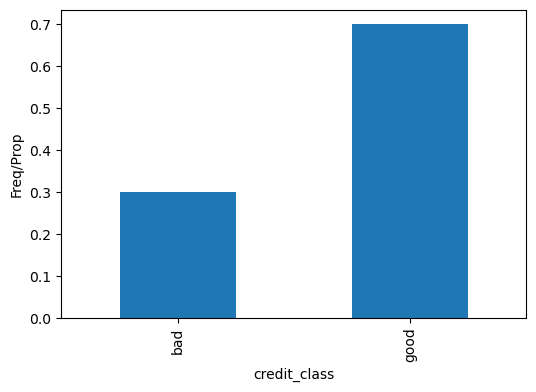

In [599]:
calc = round(df.groupby(['credit_class'])["age"].count()/df.shape[0], 2)
print('\nAverage Age by credit_class')
print(calc)

fig, ax = plt.subplots(figsize=(6,4))
ax.set_ylabel('Freq/Prop')
calc.plot(ax = ax, kind='bar', xlabel='credit_class')
plt.show()

### Credit amount

In [600]:
# average value of Credit amount?
calc = df["credit_amount"].describe()
print('\nAverage Credit amount summary statistics:\n')
print(calc)


Average Credit amount summary statistics:

count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: credit_amount, dtype: float64


In [ ]:
def plot_cat_columns(df,col_name):
    """
    Function to plot categorical columns
    """
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col_name, hue='credit_class')
    plt.title(f'Distribution of {col_name} by Credit Class')
    plt.xlabel(col_name)
    plt.ylabel('Count')
    plt.legend(title='Credit Class', loc='upper right')
    plt.show()
    fig,ax = plt.subplots(1,2, figsize=(14, 6))
    ax[0].hist(df[col_name], bins=20, density=True, alpha=0.6, color='g')
    ax[0].set_xlabel(col_name)
    ax[0].set_title("Histogram of "+col_name)

    ax[1].hist(df[df.credit_class=='good'][col_name],  bins=20, alpha=0.5, label='good', color='red',density=True)
    ax[1].hist(df[df.credit_class=='bad'][col_name],  bins=20, alpha=0.5, label='bad', color='blue',density=True)
    ax[1].set_xlabel(col_name)
    ax[1].legend()
    


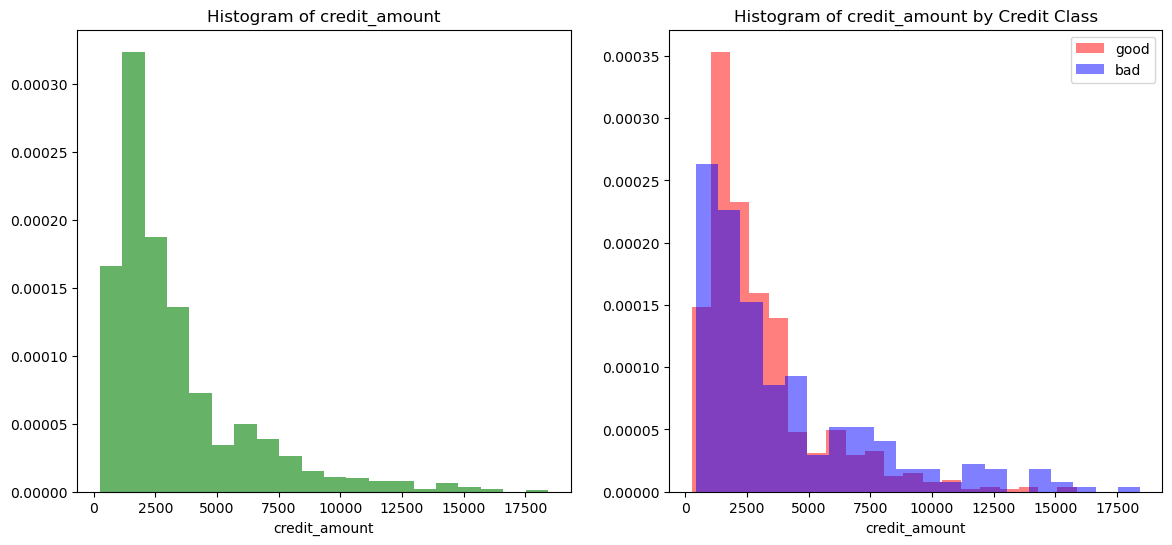

In [771]:
plot_cat_columns(df,"credit_amount")

* It seems like there is a small but noticeable difference between the distribution of `credit_amount` based on good or bad customers.
* Distribution of `credit_amount` is significantly right skewed, we may need to standardise or normalise the data before modelling.

### age

In [603]:
# what is the average value of age?
calc = df["age"].describe()
print('\nAverage Age')
print(calc)


Average Age
count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: age, dtype: float64


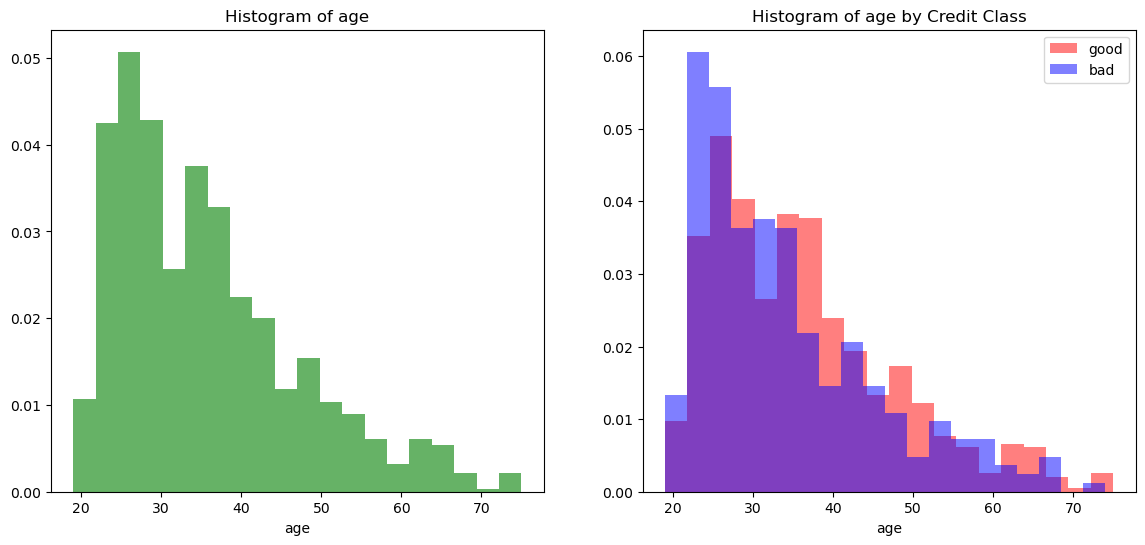

In [772]:
plot_cat_columns(df,"age")

* It seems like there is a small but noticeable difference between the distribution of `age` based on good or bad customers.
* Distribution of `age` is significantly right skewed, we may need to standardise or normalise the data before modelling.

### duration

In [606]:
# what is the average value of duration?
calc = df["duration"].describe()
print('\nAverage Duration in months')
print(calc)


Average Duration in months
count    1000.000000
mean       20.903000
std        12.058814
min         4.000000
25%        12.000000
50%        18.000000
75%        24.000000
max        72.000000
Name: duration, dtype: float64


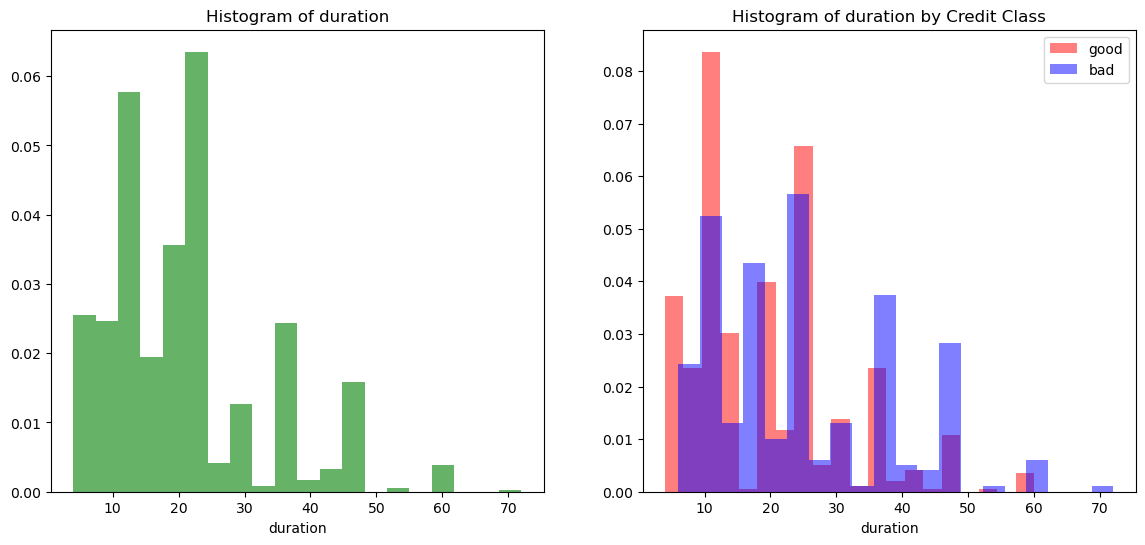

In [773]:
plot_cat_columns(df,"duration")

In [608]:
# what is the average value of  duration by credit class?
calc = df.groupby(['credit_class']).agg(Mean = ('duration', 'mean'),
                                        Std = ('duration', 'std')).reset_index()
print('\nAverage duration by credit class')
print(calc)


Average duration by credit class
  credit_class       Mean        Std
0          bad  24.860000  13.282639
1         good  19.207143  11.079564


They also tend to have significant degree of right skewness. The histogram of bad customers is clearly more skewed to the right that that of good customers

### residence_since

In [853]:
calc = df["residence_since"].describe()
print('\nAverage residence_since')
print(calc)


Average residence_since
count    1000.000000
mean        2.845000
std         1.103718
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: residence_since, dtype: float64


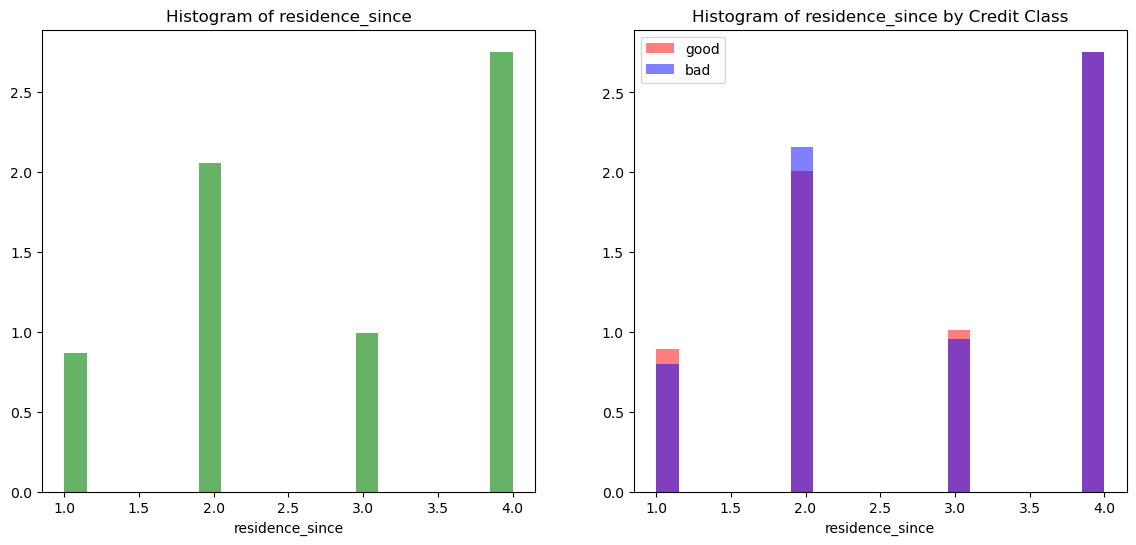

In [852]:
plot_cat_columns(df,"residence_since")

### Installment rate

In [ ]:
df_installment_commitment =  groupby_counts(df, 'installment_commitment')
print('\nDistribution of installment rate:\n')
print(df_installment_commitment) 


Distribution of installment rate:

   installment_commitment  Total  good  bad  DefaultRate
0                       1    136   102   34     0.250000
1                       2    231   169   62     0.268398
2                       3    157   112   45     0.286624
3                       4    476   317  159     0.334034


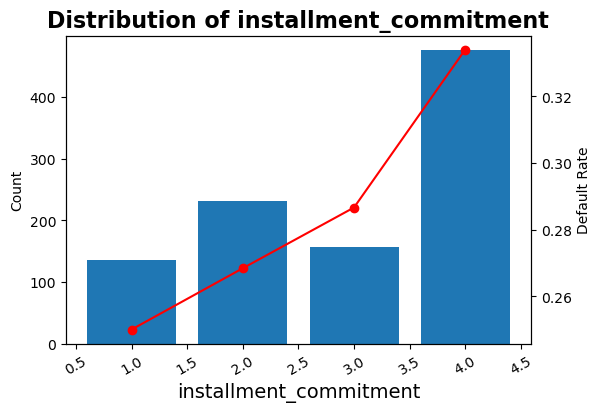

In [ ]:
plot_distribution(df_installment_commitment, 'installment_commitment')

### Account Balance

In [825]:
var = 'account_bal_new'
df_account_bal =  groupby_counts(df, var)
print('\nDistribution of ' + var + ':\n')
print(df_account_bal)


Distribution of account_bal_new:

  account_bal_new  Total  good  bad  DefaultRate
0               0    394   348   46     0.116751
1               1    274   139  135     0.492701
2               2    269   164  105     0.390335
3               3     63    49   14     0.222222


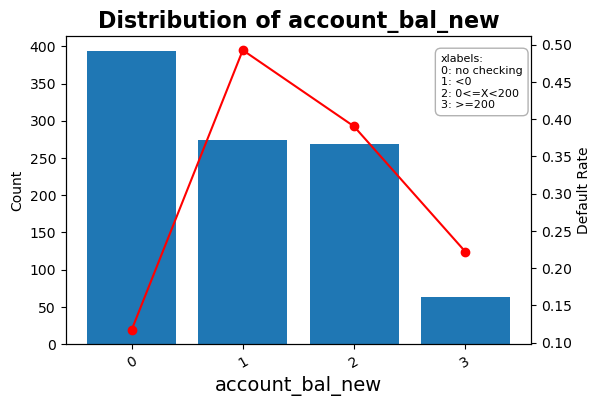

In [826]:
plot_distribution(df_account_bal, var, account_bal_map,(0.75,0.7))

### credit history

In [827]:
var = 'credit_history_new'
df_credit_history =  groupby_counts(df, var)
print('\nDistribution of credit_history:\n')
print(df_credit_history)


Distribution of credit_history:

  credit_history_new  Total  good  bad  DefaultRate
0                  0    293   243   50     0.170648
1                  1    530   361  169     0.318868
2                  2     88    60   28     0.318182
3                  3     40    15   25     0.625000
4                  4     49    21   28     0.571429


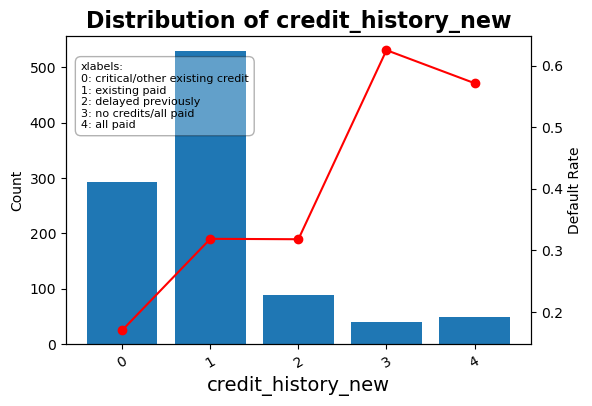

In [828]:
plot_distribution(df_credit_history, var, credit_history_map, (0.15,0.65))

### Personal status



In [614]:
df_personal_status =  groupby_counts(df, 'personal_status')
print('\nDistribution of personal_status:\n')
print(df_personal_status)


Distribution of personal_status:

      personal_status  Total  good  bad  DefaultRate
0  female div/dep/mar    310   201  109     0.351613
1        male div/sep     50    30   20     0.400000
2        male mar/wid     92    67   25     0.271739
3         male single    548   402  146     0.266423


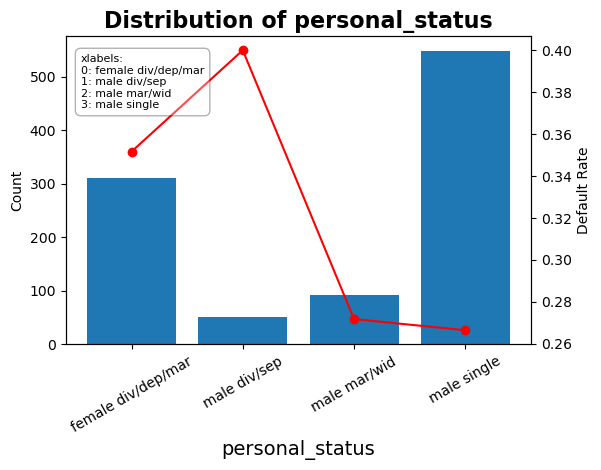

In [829]:
plot_distribution(df_personal_status, 'personal_status', personal_status_map, (0.15,0.7))

### Number of Dependents

In [616]:
df_num_dependents =  groupby_counts(df, 'num_dependents')
df_num_dependents['num_dependents'] = df_num_dependents['num_dependents'].astype(str)
print('\nDistribution of num_dependents:\n')
print(df_num_dependents)


Distribution of num_dependents:

  num_dependents  Total  good  bad  DefaultRate
0              1    845   591  254     0.300592
1              2    155   109   46     0.296774


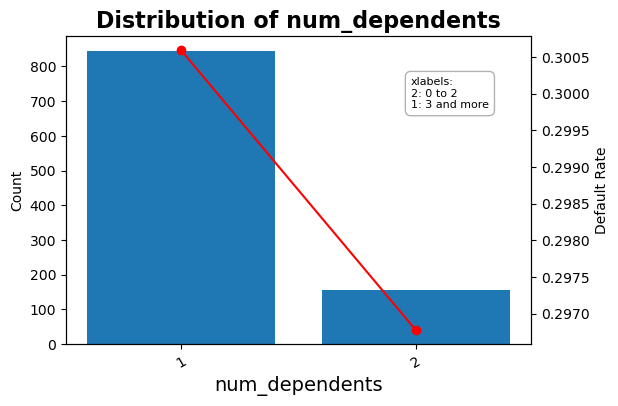

In [831]:
plot_distribution(df_num_dependents, 'num_dependents', {'0 to 2':2,'3 and more':1})

### Value of Savings

In [832]:
df_savings_value =  groupby_counts(df, 'savings_value_new')
print('\nDistribution of savings_value:\n')
print(df_savings_value)


Distribution of savings_value:

  savings_value_new  Total  good  bad  DefaultRate
0                 0    183   151   32     0.174863
1                 1    603   386  217     0.359867
2                 2    103    69   34     0.330097
3                 3     63    52   11     0.174603
4                 4     48    42    6     0.125000


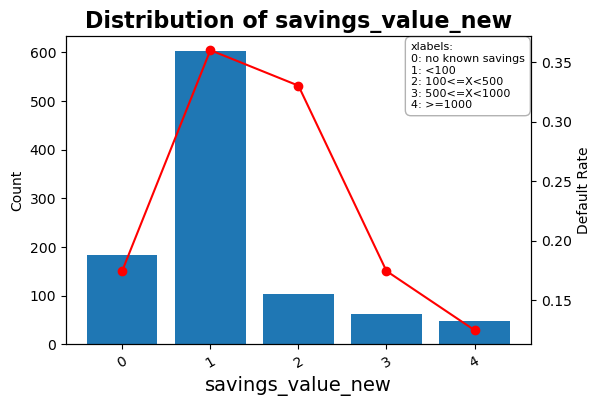

In [833]:
plot_distribution(df_savings_value, 'savings_value_new', savings_value_map, (0.7,0.7))

### Job category

In [881]:
df_job =  groupby_counts(df, 'job_new')
print('\nDistribution of job:\n')
print(df_job)


Distribution of job:

  job_new  Total  good  bad  DefaultRate
0       0    630   444  186     0.295238
1       1    200   144   56     0.280000
2       2     22    15    7     0.318182
3       3    148    97   51     0.344595


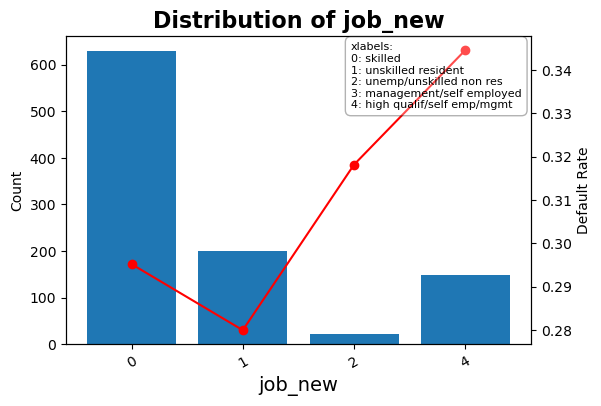

In [835]:
plot_distribution(df_job, 'job_new', job_map, (0.6,0.7))

### housing

In [836]:
df_housing =  groupby_counts(df, 'housing_new')
print('\nDistribution of housing:\n')
print(df_housing)


Distribution of housing:

  housing_new  Total  good  bad  DefaultRate
0           0    713   527  186     0.260870
1           1    108    64   44     0.407407
2           2    179   109   70     0.391061


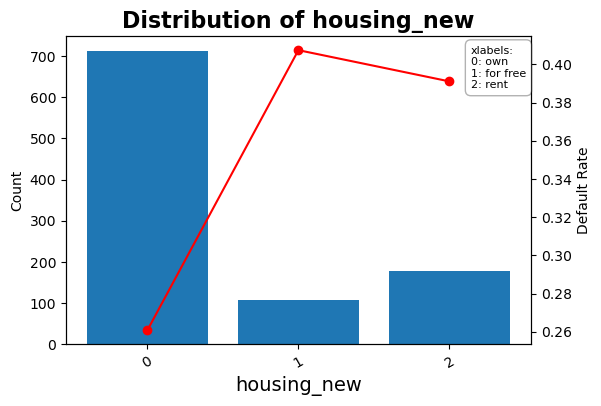

In [837]:
plot_distribution(df_housing, 'housing_new', housing_map, (0.8,0.75))

### Purpose

In [838]:
df_purpose =  groupby_counts(df, 'purpose_new')
print('\nDistribution of purpose:\n')
print(df_purpose)


Distribution of purpose:

  purpose_new  Total  good  bad  DefaultRate
0           0    280   218   62     0.221429
1           1    181   123   58     0.320442
2           2     12     8    4     0.333333
3           3     22    14    8     0.363636
4           4     50    28   22     0.440000
5           5     12     7    5     0.416667
6           6     97    63   34     0.350515
7           7    103    86   17     0.165049
8           8    234   145   89     0.380342
9           9      9     8    1     0.111111


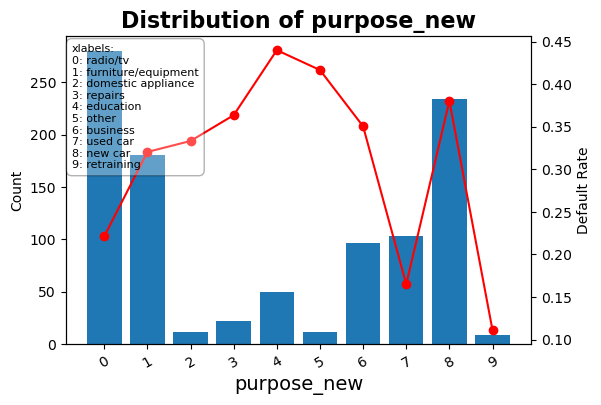

In [839]:
plot_distribution(df_purpose, 'purpose_new', purpose_map, (0.135,0.55))

### employment

In [840]:
df_employment =  groupby_counts(df, 'employment_new')
print('\nDistribution of employment:\n')
print(df_employment)


Distribution of employment:

  employment_new  Total  good  bad  DefaultRate
0              0     62    39   23     0.370968
1              1    172   102   70     0.406977
2              2    339   235  104     0.306785
3              3    174   135   39     0.224138
4              4    253   189   64     0.252964


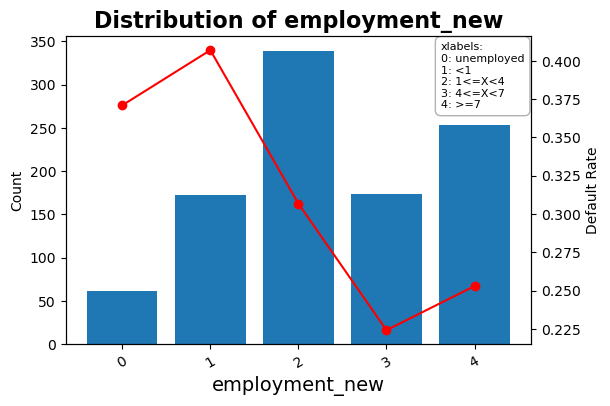

In [841]:
plot_distribution(df_employment, 'employment_new', employment_map, (0.75,0.7))

### Foreign Worker

In [842]:
df_foreign_worker =  groupby_counts(df, 'foreign_worker')
print('\nDistribution of foreign_worker:\n')
print(df_foreign_worker)


Distribution of foreign_worker:

  foreign_worker  Total  good  bad  DefaultRate
0             no     37    33    4     0.108108
1            yes    963   667  296     0.307373


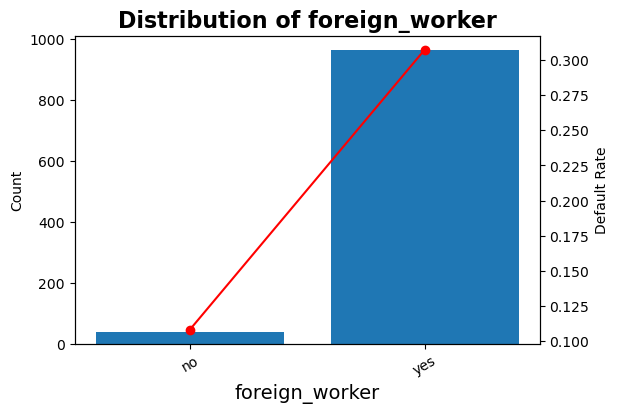

In [843]:
plot_distribution(df_foreign_worker, 'foreign_worker')

### Guarantors

In [844]:
df_guarantors =  groupby_counts(df, 'guarantors_new')
print('\nDistribution of guarantors:\n')
print(df_guarantors) 


Distribution of guarantors:

  guarantors_new  Total  good  bad  DefaultRate
0              0    907   635  272     0.299890
1              1     41    23   18     0.439024
2              2     52    42   10     0.192308


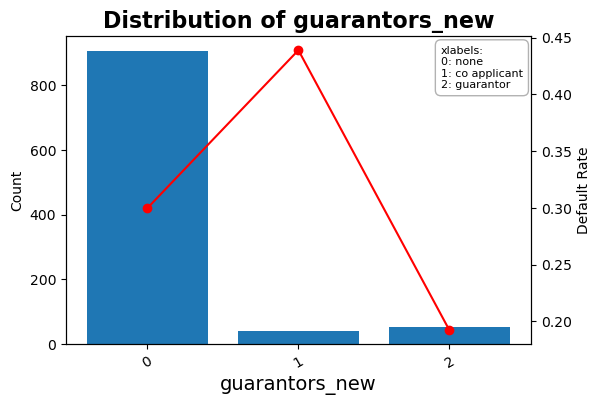

In [850]:
plot_distribution(df_guarantors, 'guarantors_new', guarantors_map, (0.75,0.75))

### Other Payment Plans

In [846]:
df_other_payment_plans =  groupby_counts(df, 'other_payment_plans_new')
print('\nDistribution of other_payment_plans:\n')
print(df_other_payment_plans) 


Distribution of other_payment_plans:

  other_payment_plans_new  Total  good  bad  DefaultRate
0                       0    139    82   57     0.410072
1                       1     47    28   19     0.404255
2                       2    814   590  224     0.275184


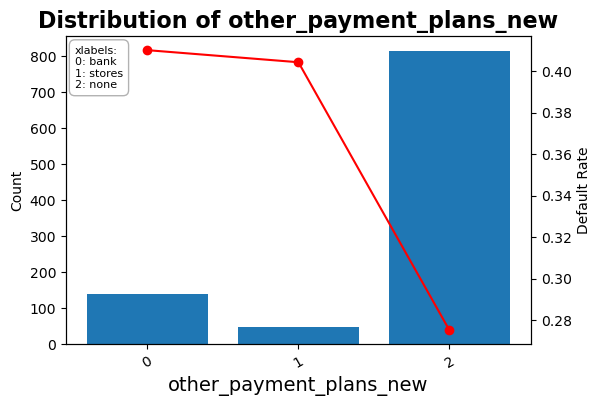

In [847]:
plot_distribution(df_other_payment_plans, 'other_payment_plans_new', other_payment_plans_map, (0.14,0.75))

### Property Magnitude

In [851]:
df_property_magnitude =  groupby_counts(df, 'property_magnitude_new')
print('\nDistribution of Property:\n')
print(df_property_magnitude) 


Distribution of Property:

  property_magnitude_new  Total  good  bad  DefaultRate
0                      0    282   222   60     0.212766
1                      1    232   161   71     0.306034
2                      2    332   230  102     0.307229
3                      3    154    87   67     0.435065


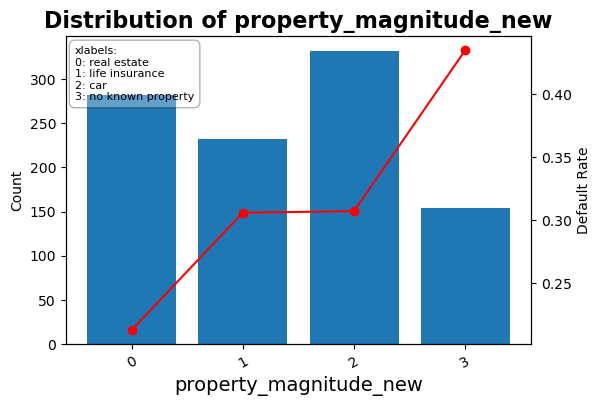

In [637]:
plot_distribution(df_property_magnitude, 'property_magnitude_new', property_magnitude_map, (0.14,0.72))

### Data Transformation

Based on the analysis performed, we need to standardise the numerical variables so that the effect of skewness and deviation from symmetry is minimised. 

In [854]:
numvars = ['age', 'credit_amount', 'duration', 'installment_commitment', 'residence_since']

In [855]:
# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(df[numvars]))
numdata_std.columns = [i + '_std' for i in numvars]
df = pd.concat([df, numdata_std], axis=1)

## **Correlation/Association Analysis**

Independent variables or attributes having high correlation or association are not preferred generally in any modelling process. This is because the model tends to be biased as the information from a correlated variable is already captured by other variables. Variable combinations having high value (>80%) for either parameter are seen as a red flag.

* For numerical variables, we use person's correlation and spearman correlation metrics to identify correlated pairs of variables. We also perform VIF test to see if any attribute is excessively correlated with a combination of other variables. 

* For categorical variables, we use Cramer's V and chi-square statistic. Chi square test tells us if there is significant relationship between the categorical variables  and Cramers' V tells us the effective size of the relationship. Value of Cramers' V > 0.20 is considered significant enough.

### **Numeric Columns**

Calculate Spearman and Peearson correlation between pairs of variables.

In [640]:
numcols = ['age_std', 'credit_amount_std', 'residence_since_std', 'installment_commitment_std', 'duration_std']

In [857]:
corr_table = continuous_correlation_table(df, numcols)
corr_table.sort_values(by="pearson_rho", ascending=False)

,variable1,variable2,pearson_rho,pearson_p,spearman_rho,spearman_p
6,credit_amount_std,duration_std,0.624984,1.862851e-109,0.624709,2.469459e-109
1,age_std,residence_since_std,0.266419,1.037262e-17,0.234709,5.556995e-14
9,installment_commitment_std,duration_std,0.074749,1.807312e-02,0.118046,1.830230e-04
2,age_std,installment_commitment_std,0.058266,6.550689e-02,0.072157,2.249409e-02
7,residence_since_std,installment_commitment_std,0.049302,1.192154e-01,0.047507,1.332839e-01
8,residence_since_std,duration_std,0.034067,2.818090e-01,0.043671,1.676132e-01
0,age_std,credit_amount_std,0.032716,3.013388e-01,0.026298,4.061243e-01
4,credit_amount_std,residence_since_std,0.028926,3.608336e-01,0.023646,4.551134e-01
3,age_std,duration_std,-0.036136,2.535887e-01,-0.036316,2.512300e-01
5,credit_amount_std,installment_commitment_std,-0.271316,2.472326e-18,-0.313100,3.492654e-24


Calculate VIF test value for numeric variables.

In [861]:
calculate_vif(df, numcols)

,feature,VIF
0,const,1.000000
1,age_std,1.092565
2,credit_amount_std,1.991831
3,residence_since_std,1.079726
4,installment_commitment_std,1.220177
5,duration_std,1.855433


Multicollinearity based on VIF values are defined as follows;

* `1`: No multicollinearity
* `1–5`: Moderate multicollinearity
* `>5`:	High multicollinearity (concerning)
* `>10`: Very high; consider removing variable

Based on these thresholds we could comment that no significant multicollinearity exists in the data among numeric fields. 

The largest paired correlation between any two variables is around 60%, which is moderate and passable. 

### **Categorical Columns**

Calculate cramer's V and chi sqauate test statistic.

In [888]:
cat_columns = [
'account_bal_new', 'credit_history_new', 'personal_status_new',
'savings_value_new', 'employment_new','housing_new', 'job_new', 'guarantors_new', 'other_payment_plans_new',
'property_magnitude_new', 'purpose_new']

In [887]:
association_table = categorical_association_table(df, cat_columns)
association_table.sort_values(by="Cramér's V", ascending=False)

,variable1,variable2,Cramér's V,Chi-Square p-value
43,housing_new,property_magnitude_new,0.553181,5.960170e-129
35,employment_new,job_new,0.311312,4.109783e-55
16,credit_history_new,other_payment_plans_new,0.215368,1.274383e-16
44,housing_new,purpose_new,0.210169,2.861352e-11
54,property_magnitude_new,purpose_new,0.205818,6.347286e-15
48,job_new,purpose_new,0.202844,2.748555e-14
21,personal_status_new,housing_new,0.202165,1.559793e-15
47,job_new,property_magnitude_new,0.193905,3.958440e-20
2,account_bal_new,savings_value_new,0.175569,1.636530e-14
34,employment_new,housing_new,0.172929,5.081439e-10


In [886]:
# Filter for practical significance
meaningful_associations = association_table[
    (association_table["Chi-Square p-value"] < 0.05) & 
    (association_table["Cramér's V"] >= 0.20)  # Moderate or stronger
].sort_values("Cramér's V", ascending=False)

meaningful_associations

,variable1,variable2,Cramér's V,Chi-Square p-value
43,housing_new,property_magnitude_new,0.553181,5.960170e-129
35,employment_new,job_new,0.311312,4.109783e-55
16,credit_history_new,other_payment_plans_new,0.215368,1.274383e-16
44,housing_new,purpose_new,0.210169,2.861352e-11
54,property_magnitude_new,purpose_new,0.205818,6.347286e-15
48,job_new,purpose_new,0.202844,2.748555e-14
21,personal_status_new,housing_new,0.202165,1.559793e-15


We see that among categorical variables, some pairs of varibles execute some significant degree of association. For example `Housing` vs `property` and `employment` vs `job`. Logically it is reasonable that these variables would be correlated. We can visualise the relationship by using heatmaps. 

**Housing vs Property**

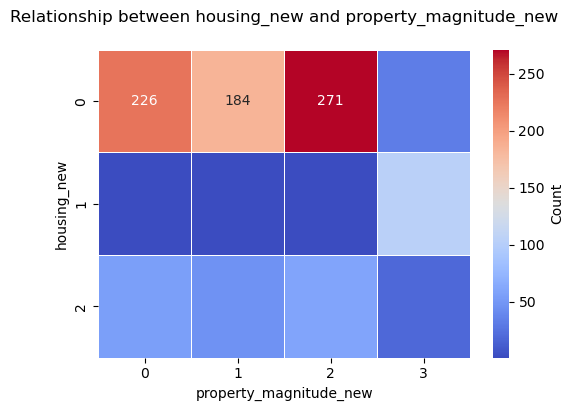

In [884]:
plot_categorical_heatmap(df, 'housing_new', 'property_magnitude_new')

**Job vs Property**

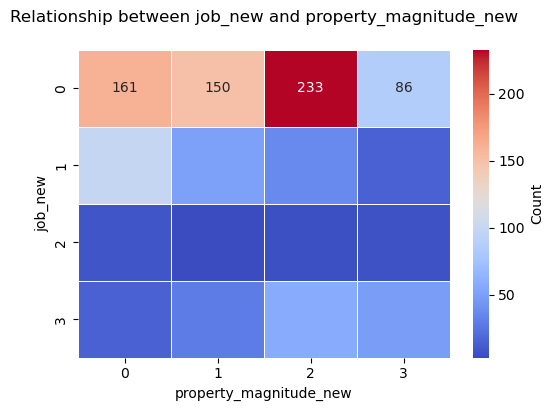

In [885]:
plot_categorical_heatmap(df, 'job_new', 'property_magnitude_new')

**Credit History vs Other Payment plans**

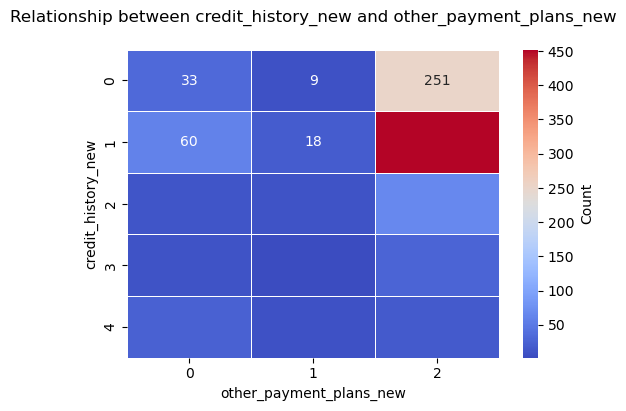

In [889]:
plot_categorical_heatmap(df, 'credit_history_new', 'other_payment_plans_new')

**Job vs Employment**

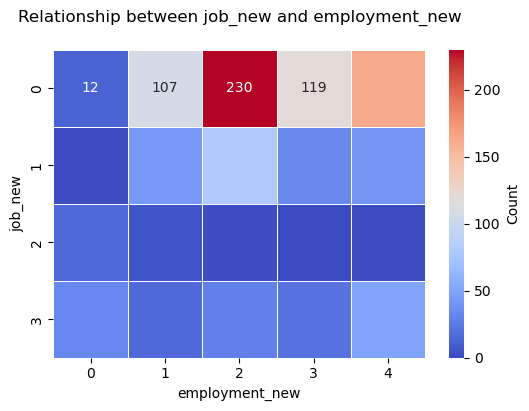

In [890]:
plot_categorical_heatmap(df, 'job_new', 'employment_new')

**Housing vs Purpose**

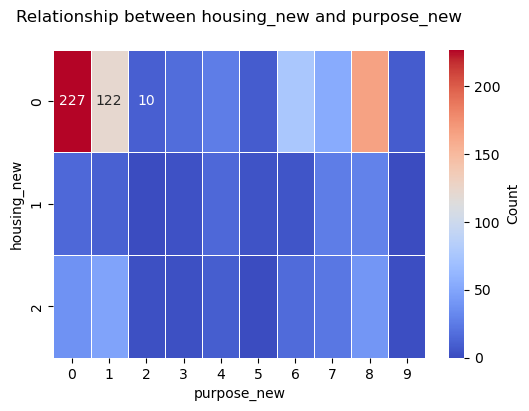

In [891]:
plot_categorical_heatmap(df, 'housing_new', 'purpose_new')

**Job vs Purpose**

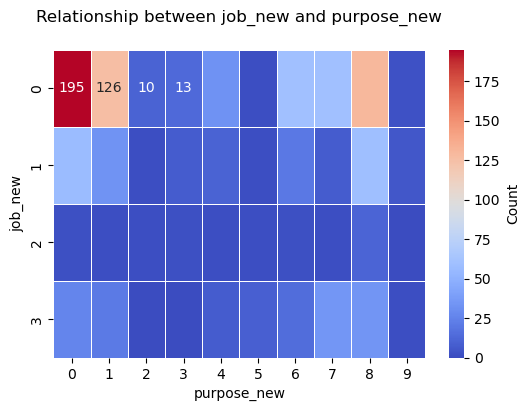

In [892]:
plot_categorical_heatmap(df, 'job_new', 'purpose_new')

Based on the analysis, we can probably exclude the following variables from the model;
* Property magnitude (as its already captured by housing and job)
* Employment (as its captured by job)
* Purpose (as its caputured in Housing and job)

## **Perform Modeling Techniques**

### **LogisticRegression**

In [652]:
df.columns

Index(['age', 'account_bal', 'credit_class', 'credit_amount', 'credit_history',
       'duration', 'employment', 'existing_credits', 'foreign_worker',
       'housing', 'installment_commitment', 'job', 'num_dependents',
       'guarantors', 'other_payment_plans', 'own_telephone', 'personal_status',
       'property_magnitude', 'purpose', 'residence_since', 'savings_value',
       'account_bal_new', 'credit_history_new', 'employment_new',
       'housing_new', 'job_new', 'guarantors_new', 'other_payment_plans_new',
       'personal_status_new', 'property_magnitude_new', 'purpose_new',
       'savings_value_new', 'age_std', 'credit_amount_std',
       'residence_since_std', 'installment_commitment_std', 'duration_std'],
      dtype='object')

In [894]:
X = pd.get_dummies(df[['account_bal_new', 
                  'credit_history_new', 
                #  'employment_new',
                  'existing_credits',
                  'foreign_worker',
                  'housing_new', 
                  'job_new', 
                  'guarantors_new', 
                  'other_payment_plans_new',       
                  'personal_status_new', 
                #  'property_magnitude_new', 
                #  'purpose_new',       
                  'savings_value_new', 
                  'age_std', 
                  'credit_amount_std',       
                  'residence_since_std', 
                  'installment_commitment_std', 
                  'duration_std'
    ]],drop_first=True)

y = df['credit_class'].map({'good':0, 'bad':1})

In [895]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12,stratify=df['credit_class'] )

In [896]:
X_train.shape

(750, 30)

In [897]:
LogisticModel = LogisticRegression(max_iter=10000, random_state=12)
LogisticModel.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=12)

In [898]:
y_prob = LogisticModel.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

In [899]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': LogisticModel.coef_[0]
}).sort_values('Feature', ascending=False)

coef_df

,Feature,Coefficient
29,savings_value_new_4,-0.063980
28,savings_value_new_3,0.583245
27,savings_value_new_2,0.812064
26,savings_value_new_1,1.158281
3,residence_since_std,-0.013471
25,personal_status_new_3,-0.305612
24,personal_status_new_2,-0.713668
23,personal_status_new_1,0.290576
22,other_payment_plans_new_2,-0.619521
21,other_payment_plans_new_1,-0.294304


In [900]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[155  20]
 [ 46  29]]
              precision    recall  f1-score   support

           0       0.77      0.89      0.82       175
           1       0.59      0.39      0.47        75

    accuracy                           0.74       250
   macro avg       0.68      0.64      0.65       250
weighted avg       0.72      0.74      0.72       250



We can see that the precision of the model using Logistic regression is moderate while recall (or sensitivity) is pretty below average. Lets perform a SMOTE resmapling to balance the number of bads and good and see if there is an improvement in performance.

**Logistic Regression with resampling**

In [ ]:
# Apply SMOTE
sm = SMOTE(sampling_strategy='auto')

X_train_re, y_train_re = sm.fit_resample(X_train, y_train)

In [906]:
LogisticModel = LogisticRegression(max_iter=10000, random_state=12)
LogisticModel.fit(X_train_re, y_train_re)

LogisticRegression(max_iter=10000, random_state=12)

In [907]:
y_prob = LogisticModel.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

In [908]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78       175
           1       0.49      0.53      0.51        75

    accuracy                           0.70       250
   macro avg       0.64      0.65      0.65       250
weighted avg       0.70      0.70      0.70       250

[[134  41]
 [ 35  40]]


As we can see rebalancing has slightly improved the recall rate but at the cost of decreased precision. Lets plot the `ROC curve` to see how well the model separates good and bad classes.

In [909]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

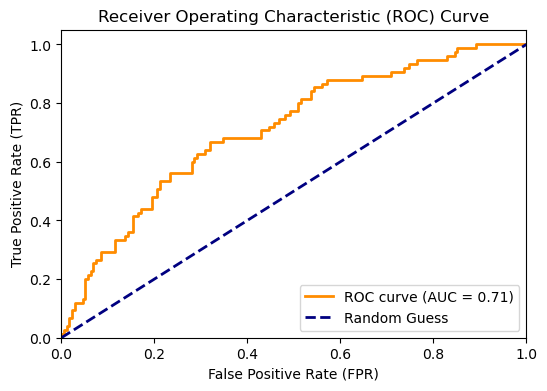

In [910]:
plot_roc_curve(fpr, tpr, roc_auc)

Lets look at other modelling techniques to see how they compare against Logistic regression. The techniqes we will follow are;

* Random Forest (simple and optimised parameter)
* Support Vector Classfier
* Naive bayes
* K-Nearest Neighbours

### **RandomForest**

In [963]:
# Initialize the model with class weighting to handle imbalance
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=13,
    class_weight='balanced'  # Adjusts for class imbalance
)
#rf.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=13)

In [913]:
# Predict on the test set
y_pred = rf.predict(X_test)

In [962]:
# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       175
           1       0.55      0.40      0.46        75

    accuracy                           0.72       250
   macro avg       0.66      0.63      0.64       250
weighted avg       0.70      0.72      0.71       250


Confusion Matrix:
[[150  25]
 [ 45  30]]


Since we performed a simple model ets use the `GridSearch` functionality in Python to see if we can optimise the RandomForest algorithm to improve model performance.

**RandomForest with Gridsearch (optimal parameters)**

In [926]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid,
    cv=5,
    scoring='f1_macro'  # Focus on F1-score for both classes
)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

Paremeters of the optimised model are

In [959]:
best_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [960]:
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

In [961]:
# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       175
           1       0.55      0.40      0.46        75

    accuracy                           0.72       250
   macro avg       0.66      0.63      0.64       250
weighted avg       0.70      0.72      0.71       250


Confusion Matrix:
[[150  25]
 [ 45  30]]


In [931]:
# Get predicted probabilities for class 1 (bad credit)
y_probs = best_rf.predict_proba(X_test)[:, 1]  # For Random Forest

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

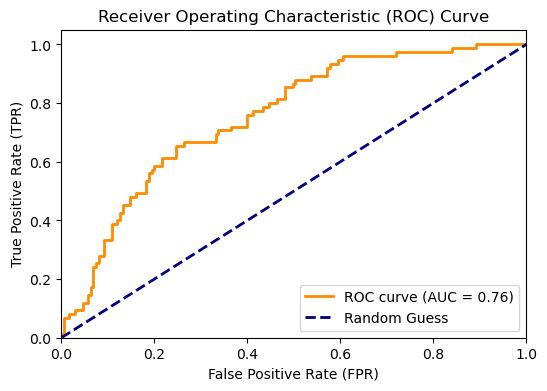

In [706]:
plot_roc_curve(fpr, tpr, roc_auc)

### **Support Vector Classifier**

In [942]:
svc = svm.SVC(kernel='poly',degree=1,probability=True,C=2,class_weight="balanced")
svc.fit(X_train, y_train)
# Predict target variables y for test data
y_pred = svc.predict(X_test)

In [943]:
# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.69      0.75       175
           1       0.48      0.68      0.56        75

    accuracy                           0.68       250
   macro avg       0.66      0.68      0.66       250
weighted avg       0.73      0.68      0.70       250


Confusion Matrix:
[[120  55]
 [ 24  51]]


In [944]:
# Get predicted probabilities for class 1 (bad credit)
y_probs = svc.predict_proba(X_test)[:, 1]  # For Random Forest

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

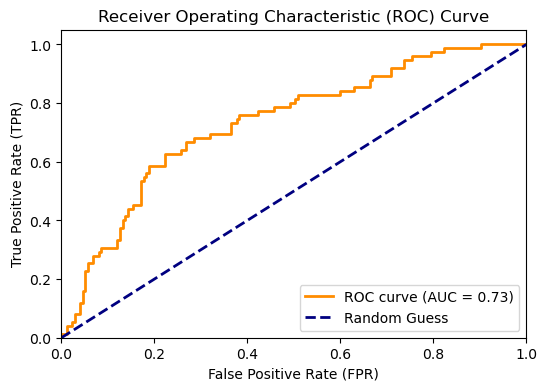

In [945]:
plot_roc_curve(fpr, tpr, roc_auc)

### **Naive Bayes**

In [946]:
GaussianNBModel = GaussianNB()
GaussianNBModel.fit(X_train, y_train)
# Predict target variables y for test data
y_pred = GaussianNBModel.predict(X_test)

In [947]:
# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.72      0.76       175
           1       0.47      0.59      0.52        75

    accuracy                           0.68       250
   macro avg       0.64      0.65      0.64       250
weighted avg       0.70      0.68      0.69       250


Confusion Matrix:
[[126  49]
 [ 31  44]]


In [948]:
# Get predicted probabilities for class 1 (bad credit)
y_probs = GaussianNBModel.predict_proba(X_test)[:, 1] 

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

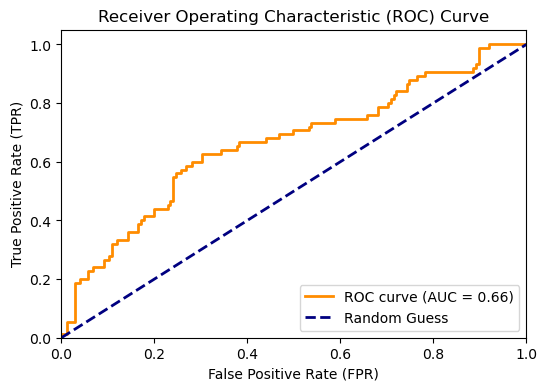

In [949]:
plot_roc_curve(fpr, tpr, roc_auc)

### **K Nearest Neighbours**

We use the resampled data here because, KNN is a distance-based classifier and tends to favor the majority class if it's overrepresented

In [956]:
KNNModel = KNeighborsClassifier(n_neighbors=3)
KNNModel.fit(X_train_re, y_train_re)
# Predict target variables y for test data  
y_pred = KNNModel.predict(X_test)

In [957]:
# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       175
           1       0.40      0.43      0.41        75

    accuracy                           0.64       250
   macro avg       0.57      0.58      0.57       250
weighted avg       0.64      0.64      0.64       250


Confusion Matrix:
[[127  48]
 [ 43  32]]


## **Conclusion**

From the above analysis, we can see that all the models offer varying levels of performance but mostly ranging from poor to fair. No models performed excelptionally well with high precision and recall. All models had decent AUC value as well.

Which model is the better among the list depends on the requirement and business decisions that we need to consider as part of model selection. For example, if it is worse to class a customer as good when they are bad , than it is to class a customer as bad when they are good, then recall rate will be the better parameter to focus into. Hence the model we elect should maximise the recall ratio and give less priority to precision. The following two models fair well in this regard; 1) Support Vector Classifier 2) Naive Bayes

On the other hand, if classifying a good customer as bad is worse than classifying a bad customer as good,  then the model should be the one that maximises the precision instead of recall, example Random Forest.

We could also use F1 score, which is a type of average of both recall and precision, if we need to focus on both the parameters. From the models performed, Support Vector Classifier offers the highest F1 score combined with decend AUC score.
